In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
from collections import Counter

# RDKit related libraries
import rdkit as rd
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDConfig
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.rdMolDescriptors import GetAtomPairFingerprint
from rdkit.Chem.AtomPairs import Torsions

# modélisation
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from rdkit.Chem.Draw import IPythonConsole

import tempfile
import deepchem as dc
import tensorflow as tf

# Graphes
import matplotlib.pyplot as plt
import seaborn as sns

Traceback (most recent call last):
  File "/home/souiai/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'
Using TensorFlow backend.


 **1. Data manipulation**

In [3]:
data = pd.read_csv (r'./AID_1063_datatable_smiles_label.csv')
data.head()

,Unnamed: 0,PUBCHEM_RESULT_TAG,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,smiles,label
0,0,1,16191685,Active,40,COC1=C(C=C(C=C1)F)C(=O)C2CCCN(C2)CC3=CC4=C(C=C...,1.0
1,1,2,585328,Active,40,CCOC(=O)C1CCN(CC1)C(=O)C23CC4CC(C2)CC(C4)C3,1.0
2,2,3,2868411,Active,40,CN1C2=CC=CC=C2N(C1=N)CC(C3=CC=CC4=CC=CC=C43)O.Cl,1.0
3,3,4,9549642,Active,40,CN1CCC(CC1)C2C3=CC=CC=C3SC4=C(O2)C=C(C=C4)Cl.C...,1.0
4,4,5,5725106,Active,40,CCOC(=O)/C(=C\C1=CC=C(C=C1)[N+](=O)[O-])/C(=O)...,1.0


In [4]:
conditions = [
    (data['label'] == 1),
    (data['label'] == 0),
    (data['label'] == 2 )]
choices = ['Active', 'Inactive', 'Unkown']
data['status'] = np.select(conditions, choices,default='unkown')
data.head()

,Unnamed: 0,PUBCHEM_RESULT_TAG,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,smiles,label,status
0,0,1,16191685,Active,40,COC1=C(C=C(C=C1)F)C(=O)C2CCCN(C2)CC3=CC4=C(C=C...,1.0,Active
1,1,2,585328,Active,40,CCOC(=O)C1CCN(CC1)C(=O)C23CC4CC(C2)CC(C4)C3,1.0,Active
2,2,3,2868411,Active,40,CN1C2=CC=CC=C2N(C1=N)CC(C3=CC=CC4=CC=CC=C43)O.Cl,1.0,Active
3,3,4,9549642,Active,40,CN1CCC(CC1)C2C3=CC=CC=C3SC4=C(O2)C=C(C=C4)Cl.C...,1.0,Active
4,4,5,5725106,Active,40,CCOC(=O)/C(=C\C1=CC=C(C=C1)[N+](=O)[O-])/C(=O)...,1.0,Active


**2. Statistics**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65057 entries, 0 to 65056
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                65057 non-null  int64  
 1   PUBCHEM_RESULT_TAG        65057 non-null  int64  
 2   PUBCHEM_CID               65057 non-null  int64  
 3   PUBCHEM_ACTIVITY_OUTCOME  65057 non-null  object 
 4   PUBCHEM_ACTIVITY_SCORE    65057 non-null  int64  
 5   smiles                    65057 non-null  object 
 6   label                     65057 non-null  float64
 7   status                    65057 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 4.0+ MB


In [7]:
data['label'].unique()

array([1., 0.])

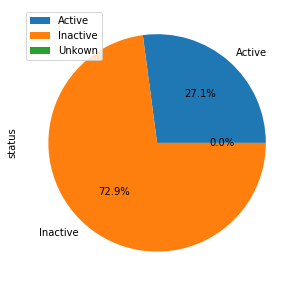

In [8]:
data1=data
type_counts = data['status'].value_counts()
data1 = pd.DataFrame({'status': type_counts}, 
                     index = choices 
                   )
data1.plot.pie(y='status', figsize=(5,5), autopct='%1.1f%%')

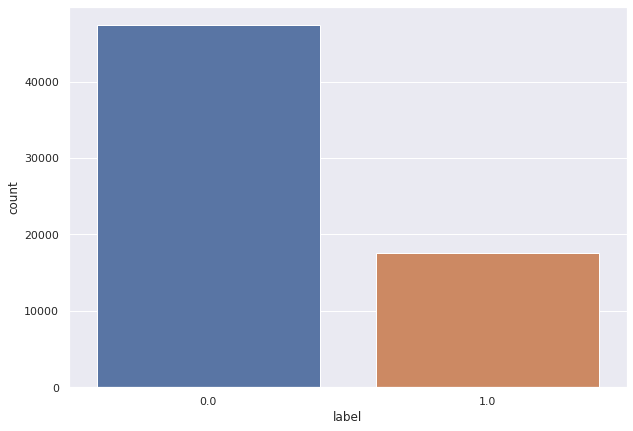

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
plt.figure(figsize=(10,7))
ax = sns.countplot(x='label', data=data)

In [10]:
(data['label']==1).sum()

17630

**3. Data encoding**

In [11]:
mols = [Chem.MolFromSmiles(x) for x in data["smiles"]]

In [12]:
len(mols)

65057

In [13]:
s=[]
for i in range(len(data)) :
    try :
        Chem.GetMorganFingerprintAsBitVect(data['mol'][i],2, nBits = 2048)
    except:
        s.append(i)
print(len(s))

65057


In [ ]:
from rdkit.Chem import Draw
sel_mols = mols[:8]
Draw.MolsToGridImage(sel_mols, molsPerRow=4, useSVG=True) #, legends=list(data['PUBCHEM_CID'][:8].values))

Chemical similarity

In [27]:
from rdkit import DataStructs
fps = [Chem.RDKFingerprint(x) for x in mols]
s=[]
for i in range(len(data)-1):
    s.append(DataStructs.FingerprintSimilarity(fps[i],fps[i+1]))
print(min(s)) 
print(max(s)) 
s=np.asarray(s)

0.010121457489878543
0.9909584086799277


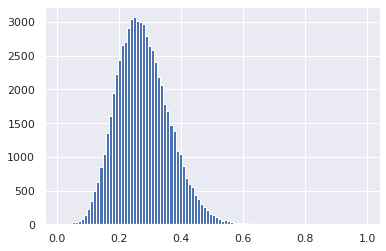

In [28]:
h=plt.hist(s, bins=100)
#plt.show()
plt.savefig('sim_hist.png', dpi=300)

In [30]:
#save the results
np.save("pw_dist.npy", s)
np.savetxt("pw_dist.csv", s, delimiter=",")

Morgan circular fingerprint

In [35]:
morg_fp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 2048) for m in mols]


morg_fp_np = []
for fp in morg_fp:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    morg_fp_np.append(arr)

np.save("ecfp4_fp.npy", morg_fp_np)

In [ ]:
morg_fp3 = [Chem.GetMorganFingerprintAsBitVect(m, 3, nBits = 2048) for m in mols]


morg_fp3_np = []
for fp in morg_fp3:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    morg_fp3_np.append(arr)

np.save("ecfp6_fp.npy", morg_fp3_np)

Daylight-like fingerprint

In [37]:

rd_fp = [Chem.RDKFingerprint(m) for m in mols]

rd_fp_np = []
for fp in rd_fp:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    rd_fp_np.append(arr)
    
np.save("rd_fp.npy", rd_fp_np)

Atom-pair fingerprint 

In [ ]:

AP_fp = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in mols]

AP_fp_np = []
for fp in AP_fp:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    AP_fp_np.append(arr)

np.save("ap_fp.npy", AP_fp_np)

Topological torsion fingerprints

In [ ]:

torsion_fp = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in mols]

torsion_fp_np = []
for fp in torsion_fp:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    torsion_fp_np.append(arr)
    
np.save("torsion_fp.npy", )

In [ ]:
#morgan fingerprints
x_morg2 = morg_fp_np
x_morg3 = morg_fp3_np

#daylight-like fingerprints
x_rd = rd_fp_np

#atom-pair fingerprints
x_AP = AP_fp_np

#topological torsion fingerprints
x_torsion = torsion_fp_np

#classification labels
y = data.label.values

In [4]:
x_morg = np.load('ecfp4_fp.npy')
y = data.label.values
#y=np.load('')

Est ce que notre dataset est equilibrée ?

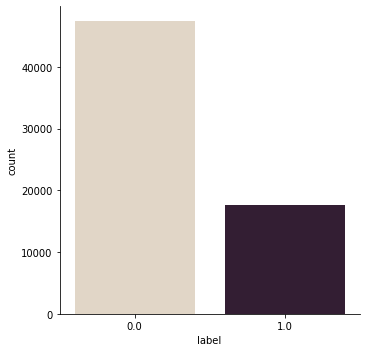

In [7]:
#y = data.label.values
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts)) 
count1 = sns.catplot(x="label", kind="count", palette="ch:.25", data=data)

## Machine Learning

#### We here only put code for the morgan fingerprints encoded data.
##### We herein used the ADASYN method for equilibration. Other algorithms may be used, such as ROS

In [ ]:
x_morg_rsmp, y_morg_rsmp = ADASYN().fit_resample(x_morg, y)
morg_sample_count = sorted(Counter(y_morg_rsmp).items())

print("Morgan distribution:", morg_sample_count)

In [ ]:
#morgan fingerprints
x_morg = morg_fp_np
x_morg_rsmp, y_morg_rsmp = ADASYN().fit_resample(x_morg, y)
morg_sample_count = sorted(Counter(y_morg_rsmp).items())

In [ ]:
np.save("x_morg.npy",morg_fp_np)

In [ ]:
y_morg_rsmp_df = pd.DataFrame(y_morg_rsmp, columns=['label'])
sns.catplot(x="label", kind="count", palette="ch:.25", data=y_morg_rsmp_df)

In [ ]:
x_morg_rsmp = morg_fp_np
y_morg_rsmp = y

In [ ]:
# Par&&&titionnement de data en 80/20 train/test split
x_morg_train, x_morg_test, y_morg_train, y_morg_test = train_test_split(x_morg_rsmp, y_morg_rsmp, test_size=0.2, random_state=1)
# training data en 80/20 train/validtion split 
x_morg_train, x_morg_val, y_morg_train, y_morg_val = train_test_split(x_morg_train, y_morg_train, test_size=0.2, random_state=1)


**LINEAR REGRESSION **

In [11]:
#set our linear regression function
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)

In [12]:
# A function to train the logistic regression classifier on given x and y training sets
def lrCV_model(x_train, y_train):
    lr = LogisticRegression(solver = 'lbfgs', max_iter = 650)
    model_accuracy = cross_val_score(lr, x_train, y_train, scoring='accuracy', cv = 5)
    accuracy_printout = "Accuracy of Model with Cross Validation is:",model_accuracy.mean() * 100, "(+/- %0.2f)" % model_accuracy.std()
    lr_fit = LogisticRegressionCV(cv=5, solver = 'lbfgs', max_iter = 650, multi_class = "ovr", n_jobs = -1).fit(x_train, y_train)
    
    return lr_fit
#train logistic regression models for all fingerprints
lr_morg = lrCV_model(x_morg_train, y_morg_train)


**3.2.1.1 REGRESSION LINEAIRE Morgan circular fingerprint**




In [13]:
accuracy_morg = cross_val_score(lr, x_morg_train, y_morg_train, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",accuracy_morg.mean() * 100, "(+/- %0.2f)" % accuracy_morg.std())
lr_morg_ = LogisticRegressionCV(cv=10, solver = 'lbfgs', max_iter = 1000).fit(x_morg_train, y_morg_train)

Accuracy of Model with Cross Validation is: 75.18250642698139 (+/- 0.01)



KeyboardInterrupt



In [ ]:
#prediction en utilisant test set et matrice de confusion
predictions_morg_test = lr_morg.predict(x_morg_test)
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)
print(cm_morg_test)

[[127  13]
 [  5 136]]


In [ ]:
#prediction en utilisant validation set et matrice de confusion 
predictions_morg_val = lr_morg.predict(x_morg_val)
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)
print(cm_morg_val)

[[106  11]
 [  0 108]]


In [ ]:
score_morg_test = lr_morg.score(x_morg_test, y_morg_test)
print('Accuracy of logistic regression classifier on test set:', score_morg_test)
score_morg_val = lr_morg.score(x_morg_val, y_morg_val)
print('Accuracy of logistic regression classifier on test set:', score_morg_val)

Accuracy of logistic regression classifier on train set: 0.9966555183946488
Accuracy of logistic regression classifier on test set: 0.9359430604982206
Accuracy of logistic regression classifier on test set: 0.9511111111111111


In [ ]:
print(classification_report(y_morg_val, predictions_morg_val))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       117
           1       0.91      1.00      0.95       108

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.96      0.95      0.95       225



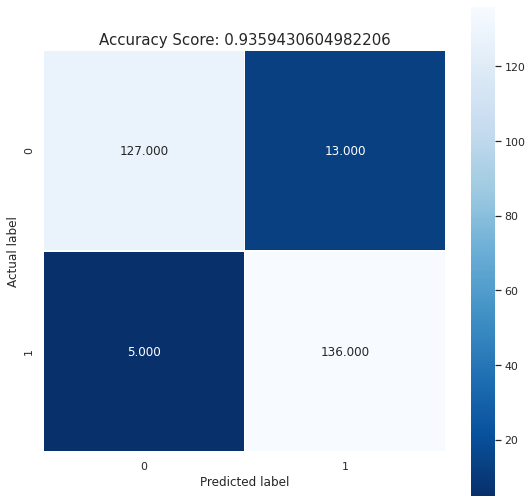

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_morg_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_morg_test)
plt.title(all_sample_title, size = 15);

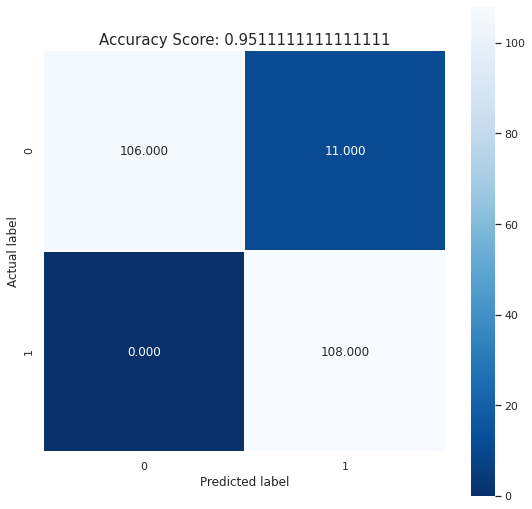

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_morg_val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_morg_val)
plt.title(all_sample_title, size = 15);

**k-nearest neighbor**

In [ ]:
knn = KNeighborsClassifier()
grid_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19], 'weights': ['distance'], 'metric': ['euclidean']}
knn_cv = GridSearchCV(knn, grid_params, cv=2, verbose = 1, n_jobs = -1)

knn_morg = knn_cv.fit(x_morg_train, y_morg_train)

knn_cv.best_params_
knn_cv.best_score_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.7s finished


0.7915233256442888

In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=3)

knn_morg = knn3.fit(x_morg_train, y_morg_train)

def mod_acc_knn(x_train, y_train, x_test, y_test):
    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn_fp = knn3.fit(x_train, y_train)
    score_fp_test_knn = knn_fp.score(x_test, y_test)
    return score_fp_test_knn

In [ ]:
x_train = x_ecfp4_train
y_train = y_ecfp4_train

x_test = x_ecfp4_test
y_test = y_ecfp4_test

print('Accuracy of knn classifier on test set:', knn_acc)
knn_acc = mod_acc_knn(x_train, y_train, x_test, y_test)
print('Accuracy of knn classifier on test set:', knn_acc)

lr_torsion = lrCV_model(x_torsion_train, y_torsion_train)
score_torsion = lr_torsion.score(x_torsion_test, y_torsion_test)
print('Accuracy of logistic regression classifier on test set:', score_torsion)

**Gradient boosting**

In [ ]:
#set search parameters
params_gb = {
    "loss":["deviance"],
    "learning_rate": [1.0],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,7],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.75, 0.95],
    "n_estimators":[100]
    }

In [ ]:
gb = GridSearchCV(GradientBoostingClassifier(), params_gb, cv=2, n_jobs=-1, verbose = 2) 
gb_morg = gb.fit(x_morg_train, y_morg_train)

#prediction en utilisant test set et matrice de confusion
predictions_morg_test = gb_morg.predict(x_morg_test)
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)
print(cm_morg_test)

#prediction en utilisant validation set et matrice de confusion 
predictions_morg_val = gb_morg.predict(x_morg_val)
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)
print(cm_morg_val)
print('Accuracy of gradient boosting classifier on test set:',gb_morg.score(x_morg_test, y_morg_test))
print('Accuracy of gradient boosting classifier on validation set:',gb_morg.score(x_morg_val, y_morg_val))

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2014 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  2.9min finished


[[115  25]
 [ 34 107]]
[[100  17]
 [ 21  87]]
Accuracy of gradient boosting classifier on train set: 0.8851727982162765
Accuracy of gradient boosting classifier on test set: 0.7900355871886121
Accuracy of gradient boosting classifier on validation set: 0.8311111111111111


**Decision Trees**

In [ ]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1)

**3.2.4.1 arbre de decision Morgan circular fingerprint**

In [ ]:
clf_gini_mog=clf_gini.fit(x_morg_train, y_morg_train)

#prediction en utilisant test set et matrice de confusion
predictions_morg_test = clf_gini_mog.predict(x_morg_test)
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)
print(cm_morg_test)

#prediction en utilisant validation set et matrice de confusion 
predictions_morg_val = clf_gini_mog.predict(x_morg_val)
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)
print(cm_morg_val)

print('Accuracy of decision tree classifier on test set:',clf_gini_mog.score(x_morg_test, y_morg_test))
print('Accuracy of decision tree classifier on validation set:',clf_gini_mog.score(x_morg_val, y_morg_val))

[[131   9]
 [ 90  51]]
[[106  11]
 [ 58  50]]
Accuracy of decision tree classifier on train set: 0.7146042363433668
Accuracy of decision tree classifier on test set: 0.6476868327402135
Accuracy of decision tree classifier on validation set: 0.6933333333333334


**Random Forest**

In [ ]:
rfc=RandomForestClassifier(n_estimators=100)

In [ ]:
rfc_mog=rfc.fit(x_morg_train, y_morg_train)

#prediction en utilisant test set et matrice de confusion
predictions_morg_test = rfc_mog.predict(x_morg_test)
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)
print(cm_morg_test)

#prediction en utilisant validation set et matrice de confusion 
predictions_morg_val = rfc_mog.predict(x_morg_val)
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)
print(cm_morg_val)

print('Accuracy of Random Forest classifier on test set:',rfc_mog.score(x_morg_test, y_morg_test))
print('Accuracy of Random Forest classifier on validation set:',rfc_mog.score(x_morg_val, y_morg_val))

[[135   5]
 [ 12 129]]
[[112   5]
 [  7 101]]
Accuracy of Random Forest classifier on train set: 0.9977703455964325
Accuracy of Random Forest classifier on test set: 0.9395017793594306
Accuracy of Random Forest classifier on validation set: 0.9466666666666667


**Naive Bayes**

In [ ]:
nb = GaussianNB()

In [ ]:
nb_mog=nb.fit(x_morg_train, y_morg_train)

#prediction en utilisant test set et matrice de confusion
predictions_morg_test = nb_mog.predict(x_morg_test)
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)
print(cm_morg_test)

#prediction en utilisant validation set et matrice de confusion 
predictions_morg_val = nb_mog.predict(x_morg_val)
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)
print(cm_morg_val)

print('Accuracy of Naive Bayes classifier on test set:',nb_mog.score(x_morg_test, y_morg_test))
print('Accuracy of Naive Bayes classifier on validation set:',nb_mog.score(x_morg_val, y_morg_val))

[[122  18]
 [  3 138]]
[[104  13]
 [  1 107]]
Accuracy of Naive Bayes classifier on train set: 0.967670011148272
Accuracy of Naive Bayes classifier on test set: 0.9252669039145908
Accuracy of Naive Bayes classifier on validation set: 0.9377777777777778


**Spport Vector Machine**

In [ ]:
svc = SVC(random_state=42,probability=True)

In [ ]:
svc_mog=svc.fit(x_morg_train, y_morg_train)

#prediction en utilisant test set et matrice de confusion
predictions_morg_test = svc_mog.predict(x_morg_test)
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)
print(cm_morg_test)

#prediction en utilisant validation set et matrice de confusion 
predictions_morg_val = svc_mog.predict(x_morg_val)
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)
print(cm_morg_val)

print('Accuracy of Spport vector machine classifier on test set:',svc_mog.score(x_morg_test, y_morg_test))
print('Accuracy of Spport vector machine classifier on validation set:',svc_mog.score(x_morg_val, y_morg_val))

[[135   5]
 [  8 133]]
[[111   6]
 [  4 104]]
Accuracy of Spport vector machine classifier on train set: 0.9866220735785953
Accuracy of Spport vector machine classifier on test set: 0.9537366548042705
Accuracy of Spport vector machine classifier on validation set: 0.9555555555555556


**Model Comparison**

In [ ]:
def auc_calc(x_val, y_val, model):
    # Probability predictions using validation data
    prob = model.predict_proba(x_val)
    # Correct probability predictions
    prob = prob[:, 1]
    # Calculate area under the curve with validation data labels and correct predicted probabilities
    auc = metrics.roc_auc_score(y_val, prob)
    # Return the AUC score with 6 figures
    return 'AUC: %.6f' % auc
def f1score(x_val, y_val, model):
    #predictions made on validation data
    predictions = model.predict(x_val)
    #generating the classification report
    clrpt = classification_report(y_val, predictions, output_dict = True)
    #accessing the weighted average entery in dictionairy
    d = clrpt["weighted avg"]
    #calling the f1_score
    f1 = d['f1-score']
    return 'f1-score %.6f' % f1

**1. AUC**

In [ ]:
print('Linear regression',auc_calc(x_morg_val, y_morg_val, lr_morg))
print('KNN',auc_calc(x_morg_val, y_morg_val, knn_morg))
print('Gradient Boosting',auc_calc(x_morg_val, y_morg_val, gb_morg))
print('Decision trees',auc_calc(x_morg_val, y_morg_val, clf_gini_mog))
print('Random Forest',auc_calc(x_morg_val, y_morg_val, rfc_mog))
print('Naive Bayes',auc_calc(x_morg_val, y_morg_val, nb_mog))
print('SVM',auc_calc(x_morg_val, y_morg_val, svc_mog))

Regression lineaire AUC: 0.983697
knn AUC: 0.482669
gradient bosting AUC: 0.930991
Arbre de decision AUC: 0.523860
Random Forest AUC: 0.712251
Naive Bayes AUC: 0.605769
svm AUC: 0.651393


**2 f1-score**

In [ ]:
print('Linear regression',f1score(x_morg_val, y_morg_val, lr_morg))
print('KNN',f1score(x_morg_val, y_morg_val, knn_morg))
print('Gradient Boosting',f1score(x_morg_val, y_morg_val, gb_morg))
print('Decision trees',f1score(x_morg_val, y_morg_val, clf_gini_mog))
print('Random Forest',f1score(x_morg_val, y_morg_val, rfc_mog))
print('Naive Bayes',f1score(x_morg_val, y_morg_val, nb_mog))
print('SVM',f1score(x_morg_val, y_morg_val, svc_mog))

Regression lineaire f1-score 0.951090
knn f1-score 0.345014
gradient bosting f1-score 0.830937
Arbre de decision f1-score 0.416595
Random Forest f1-score 0.363551
Naive Bayes f1-score 0.606375
svm f1-score 0.375337
